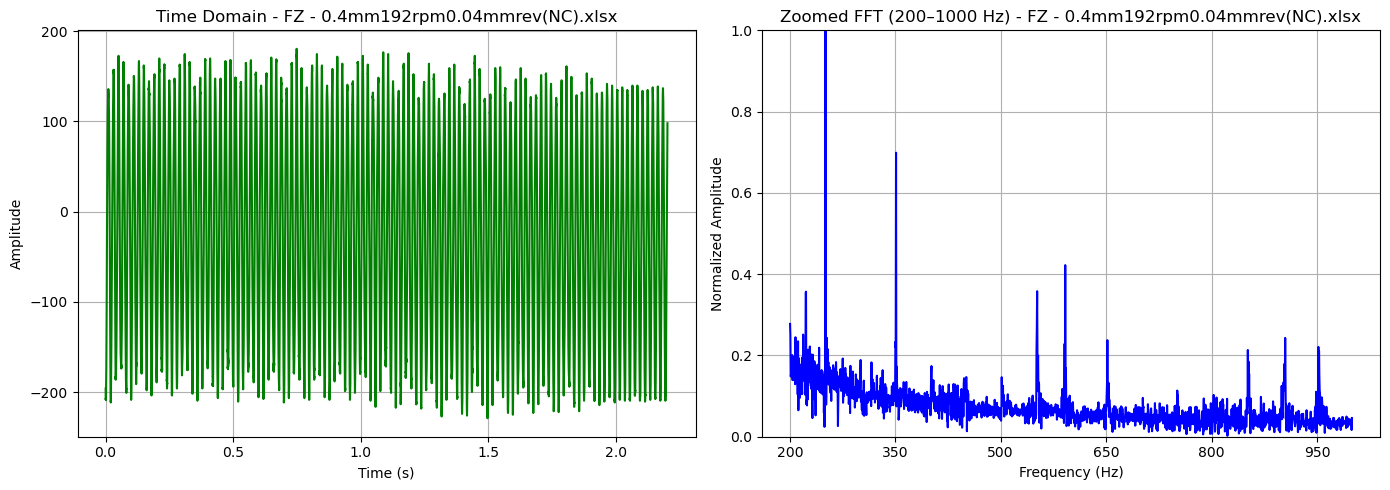

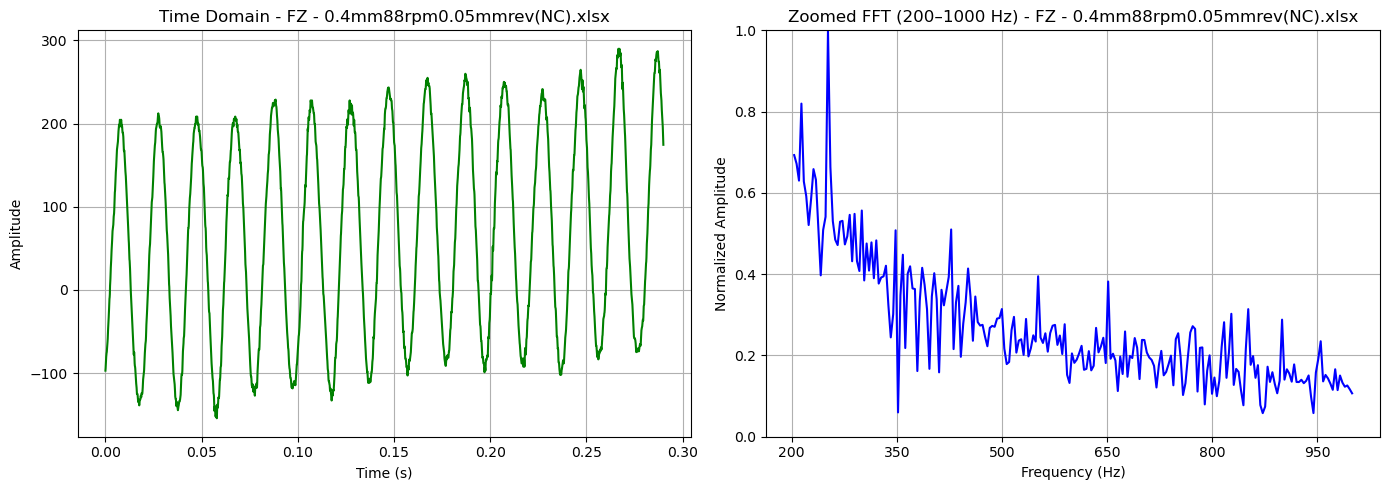

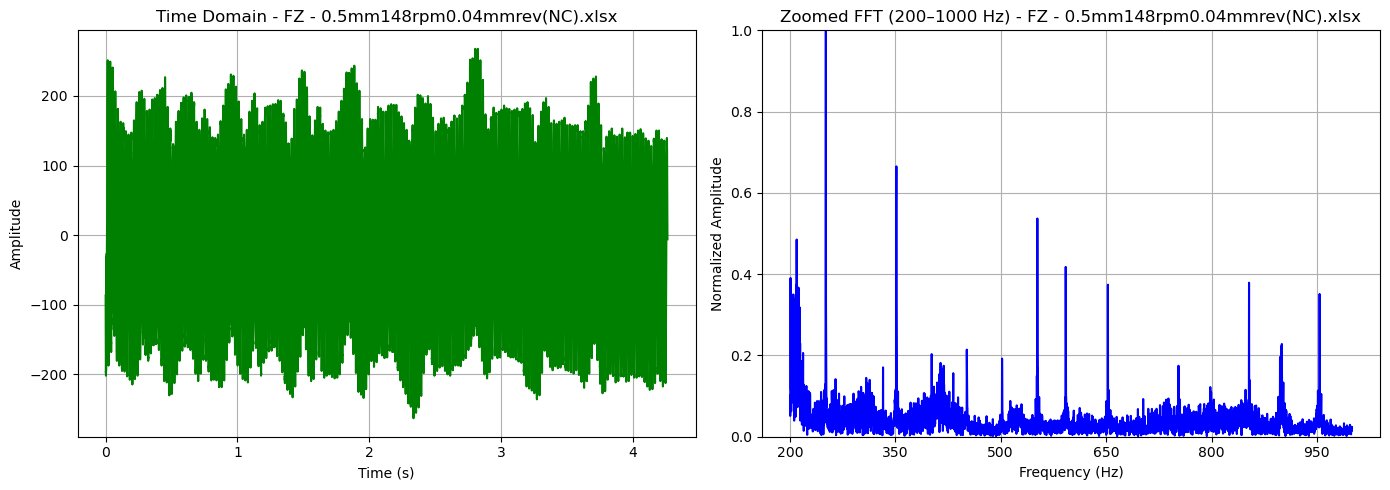

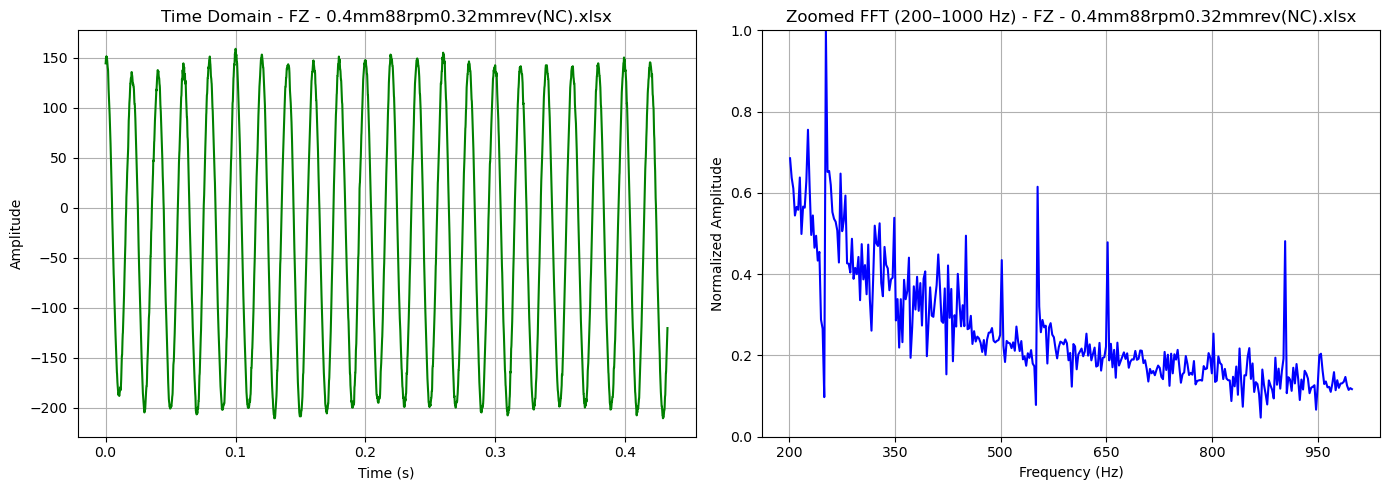

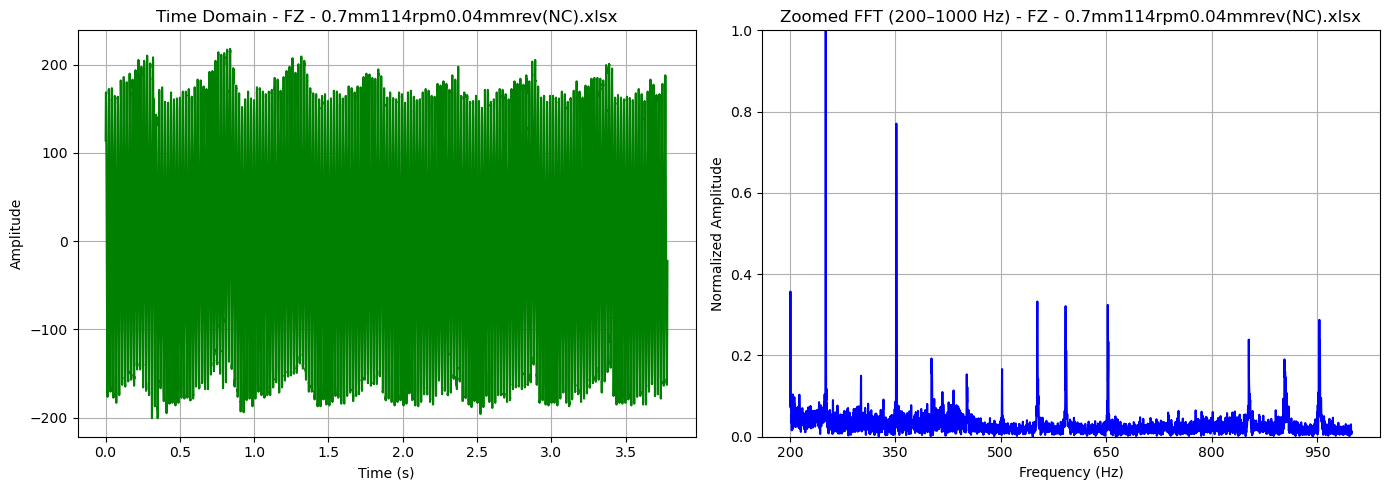

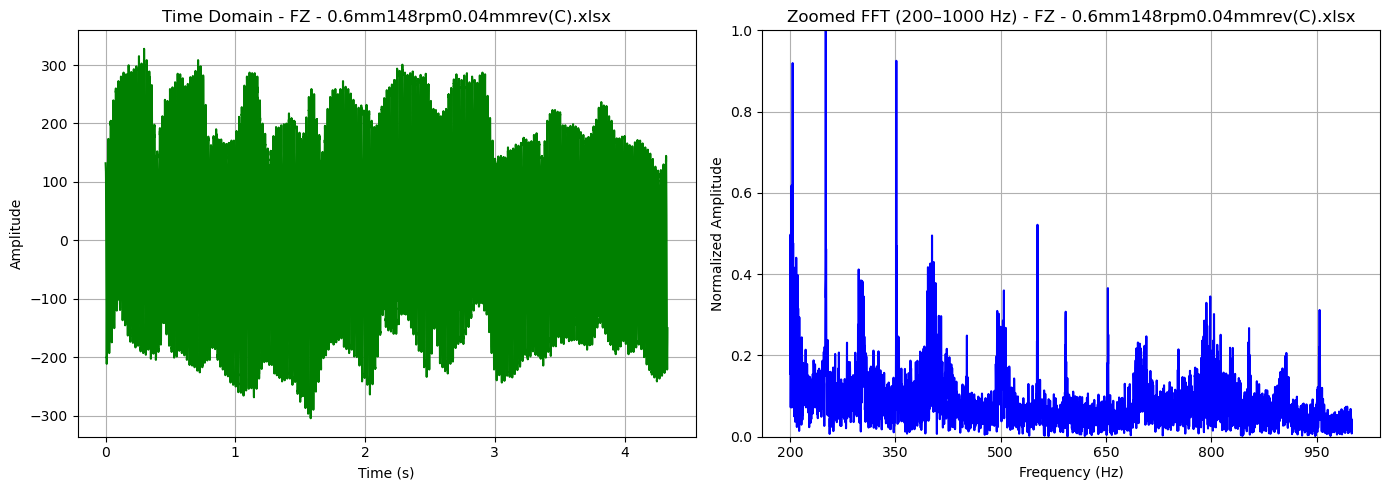

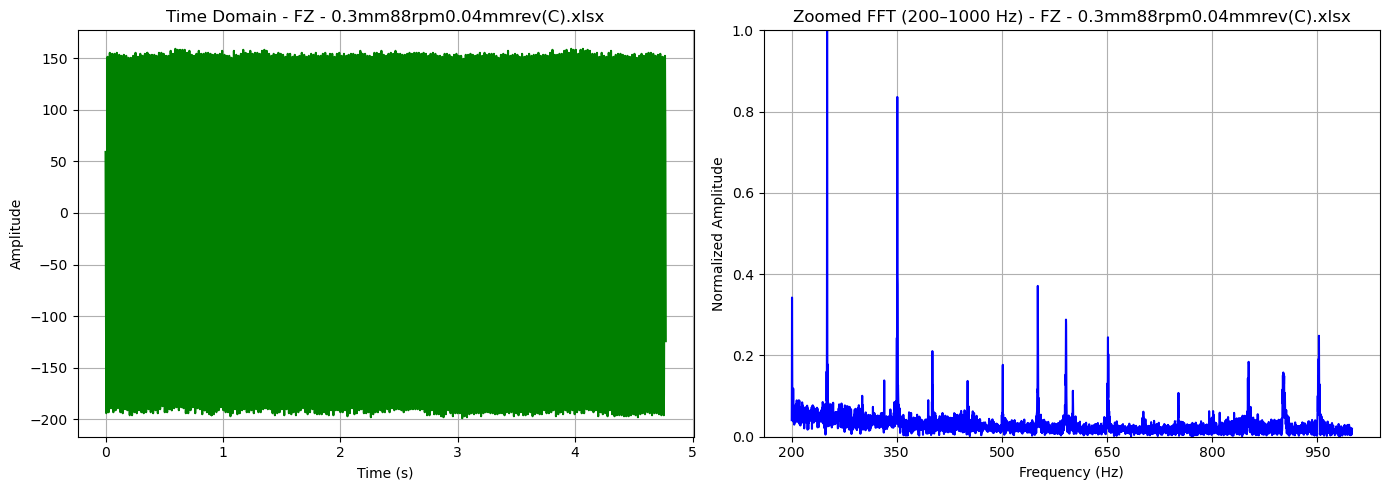

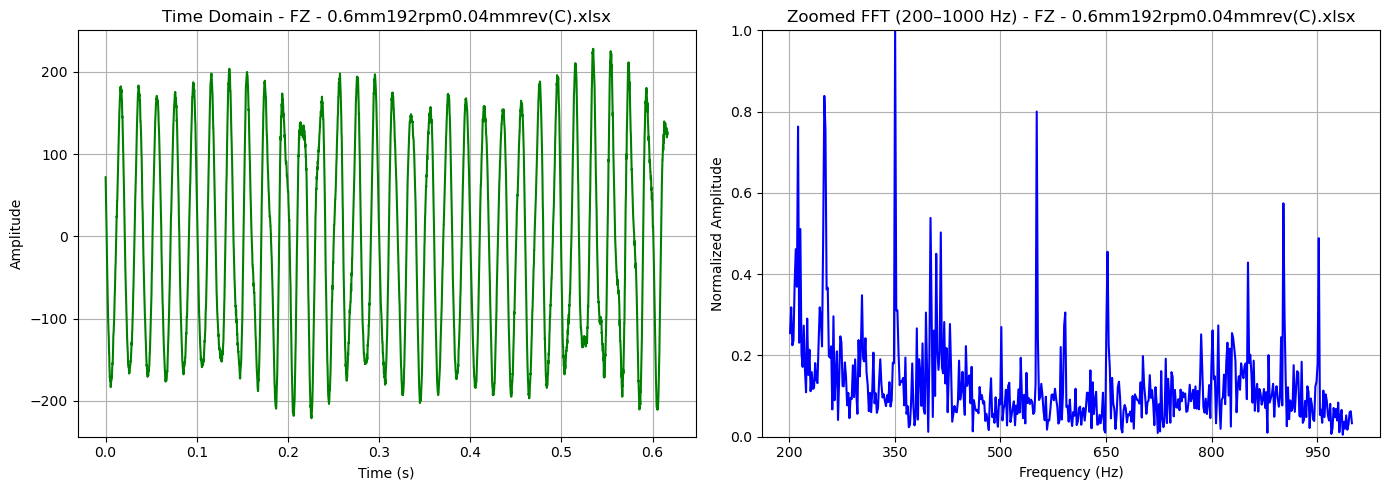

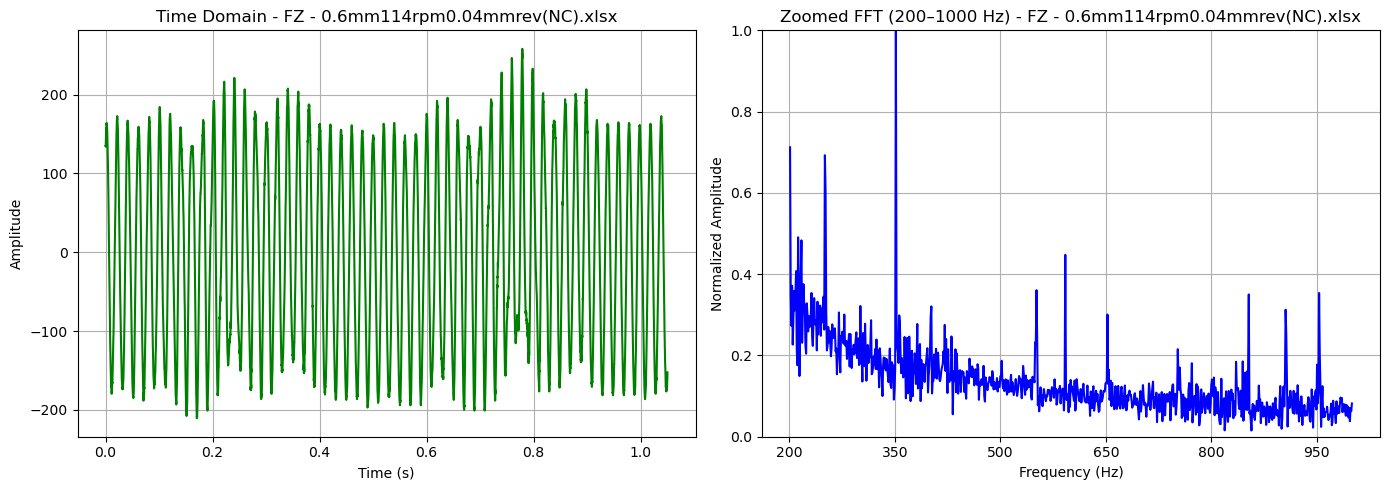

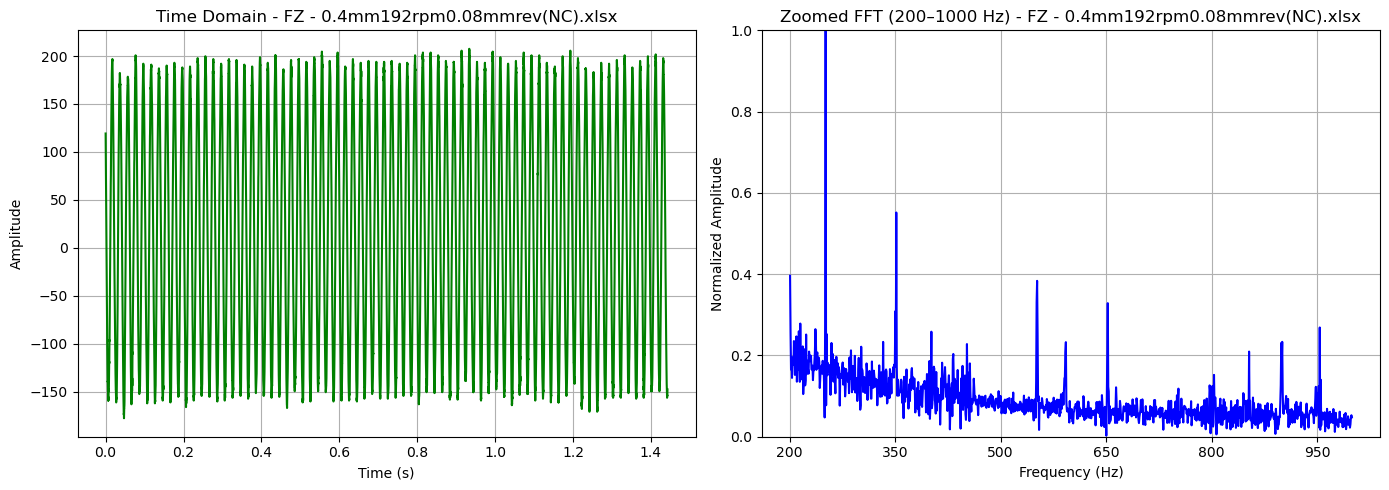

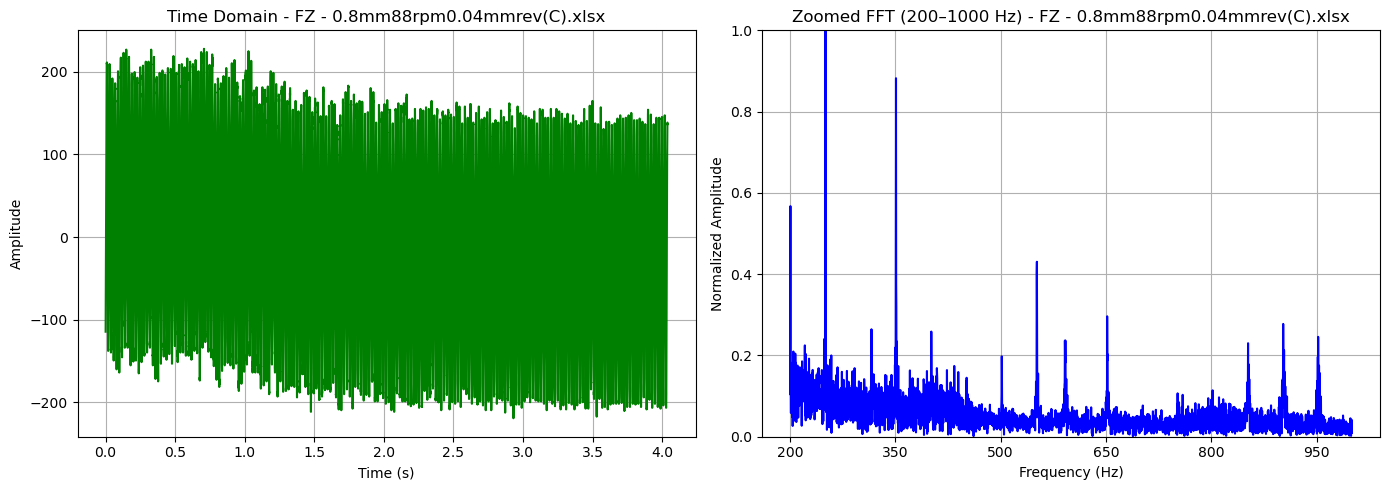

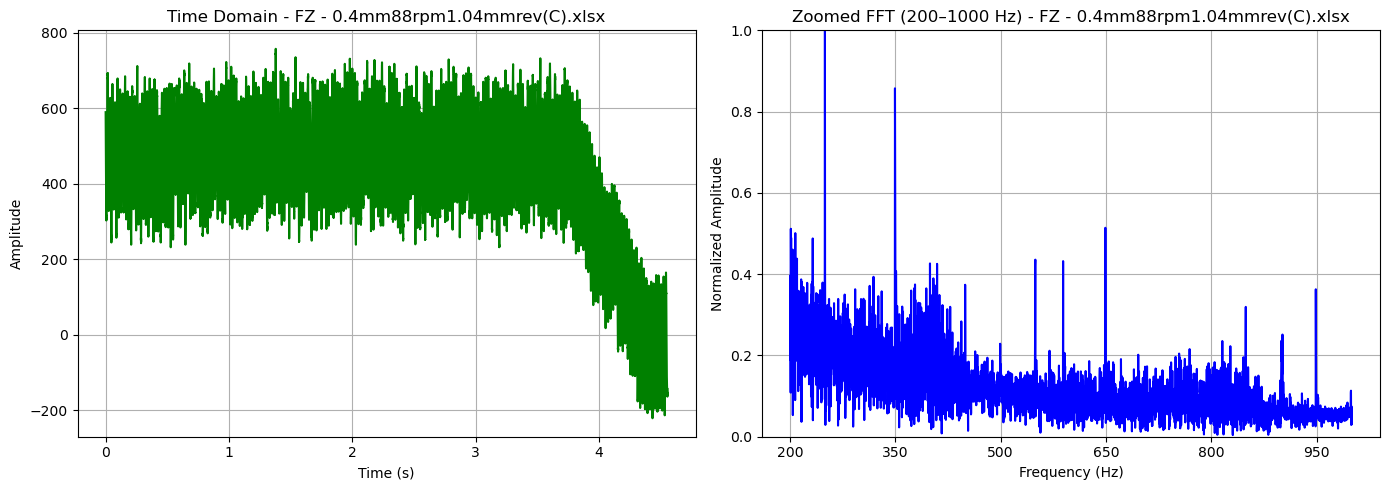

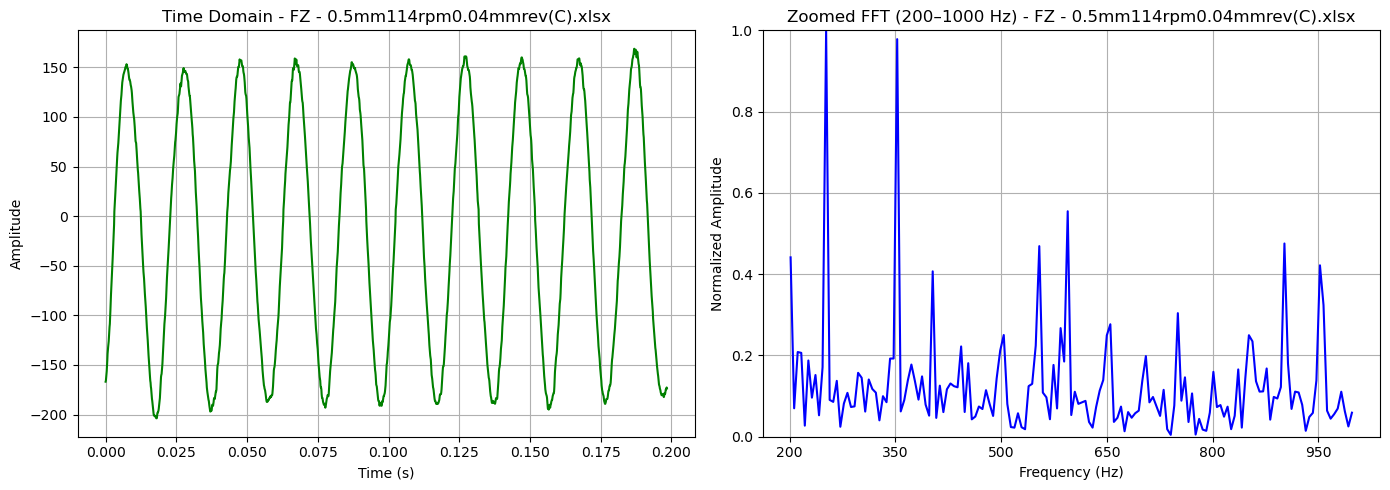

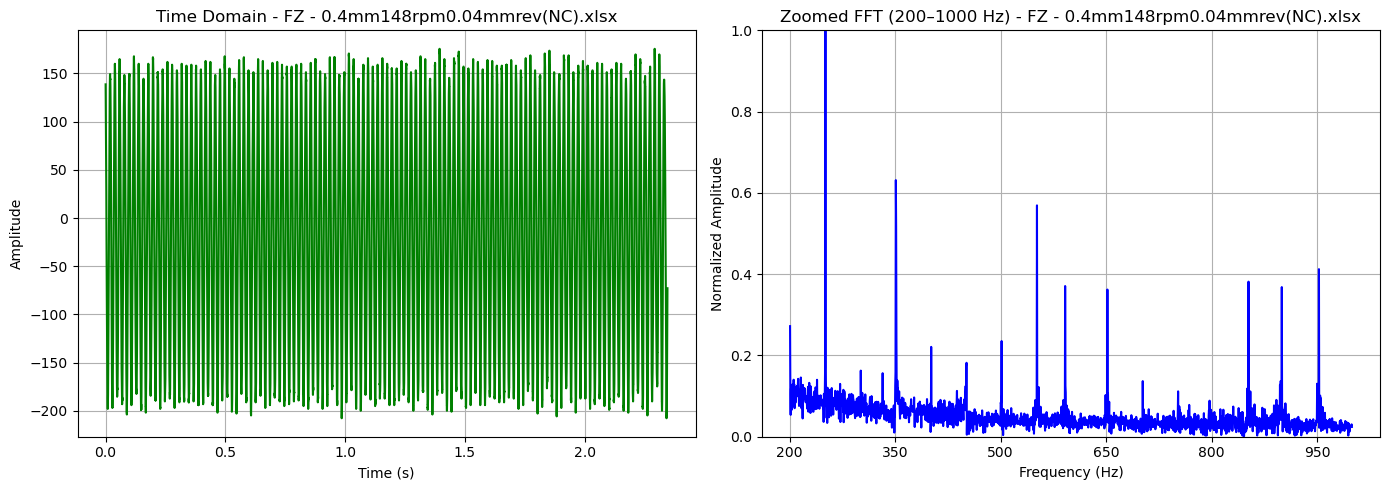

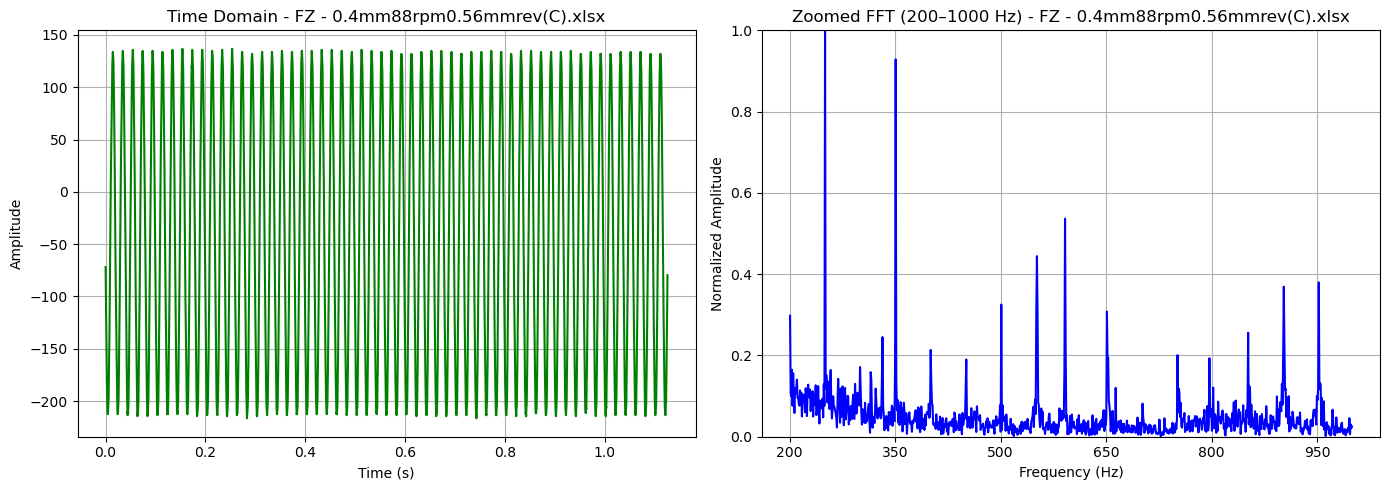

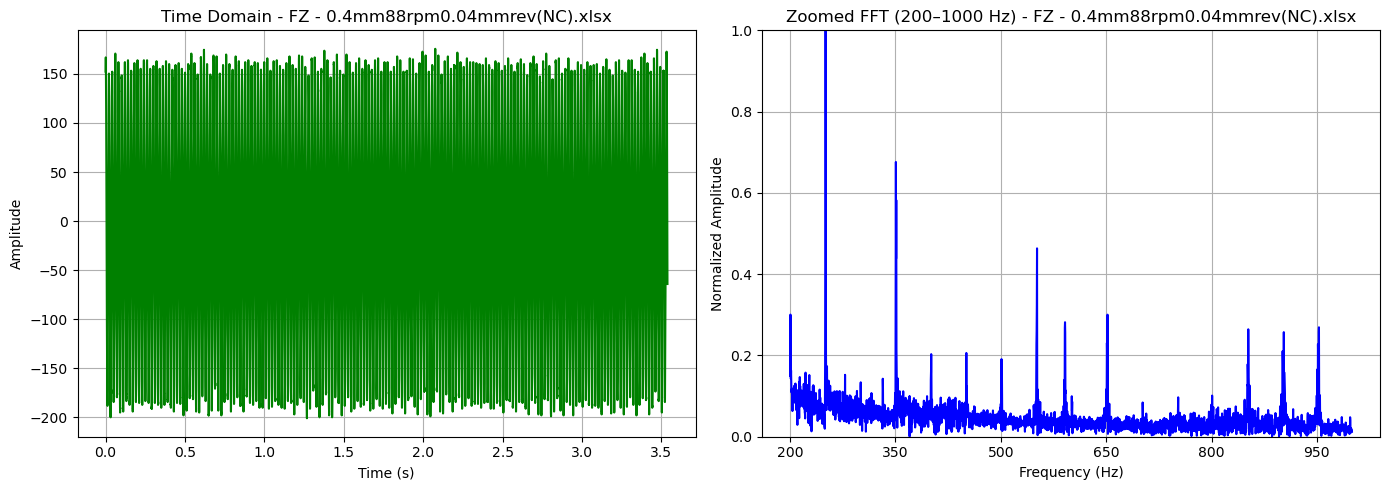

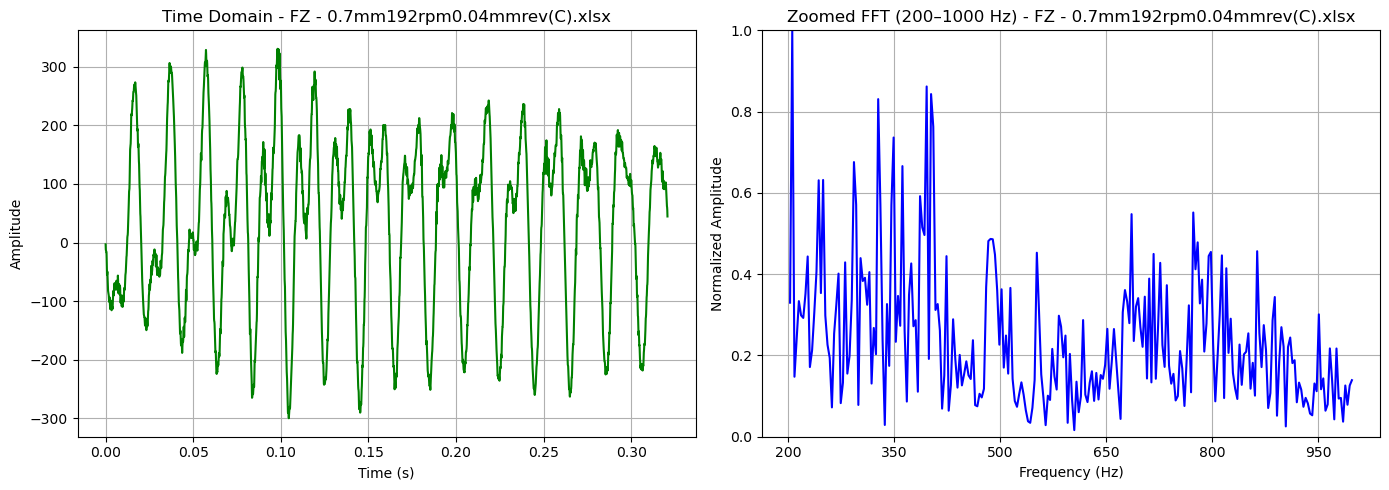

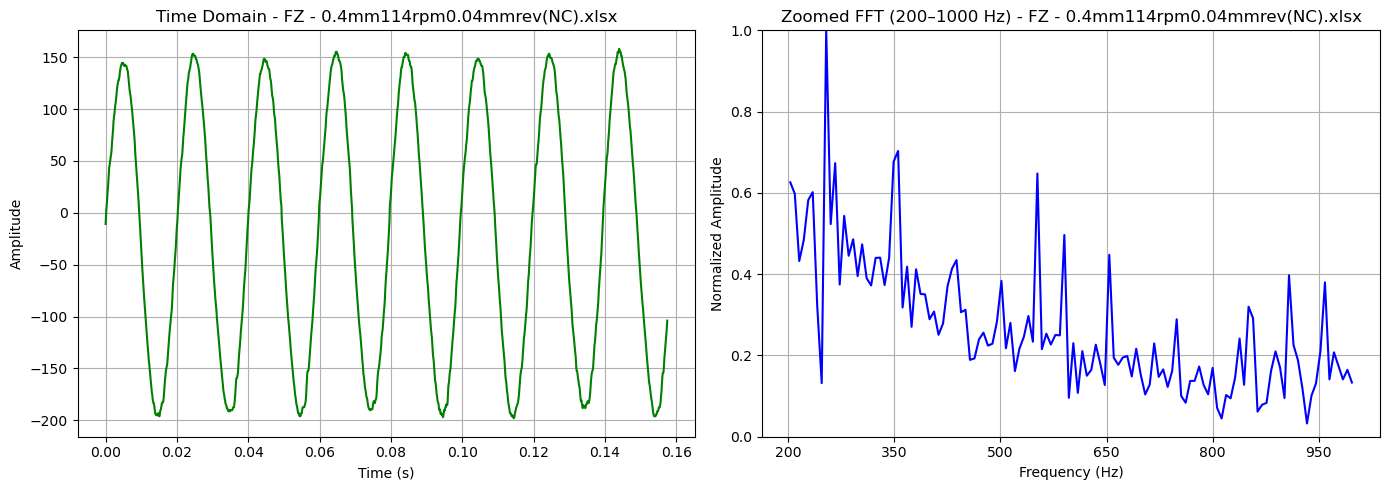

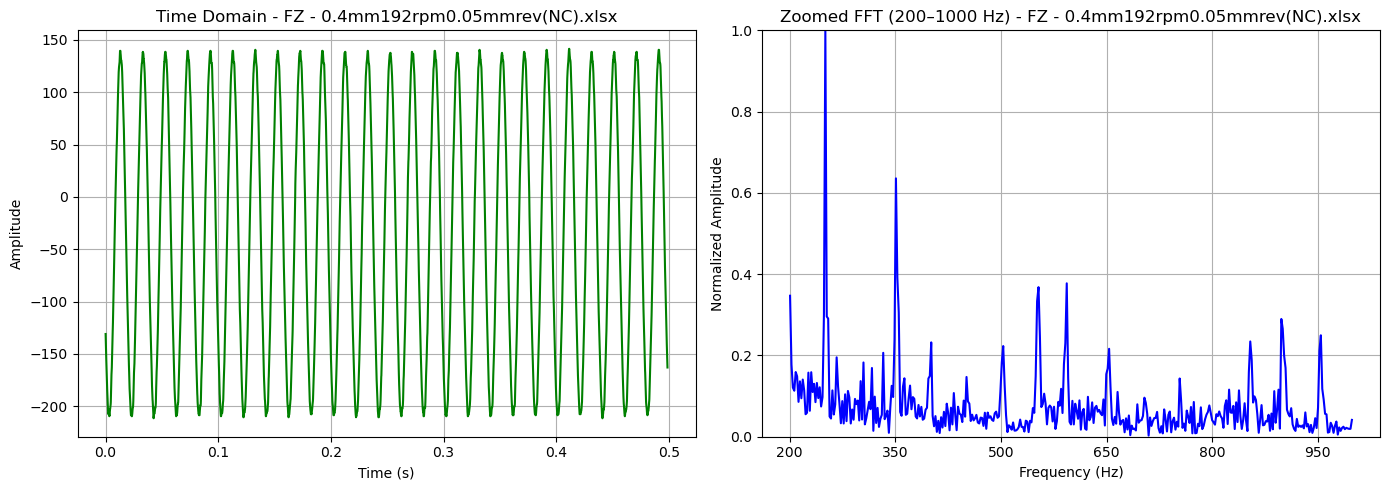

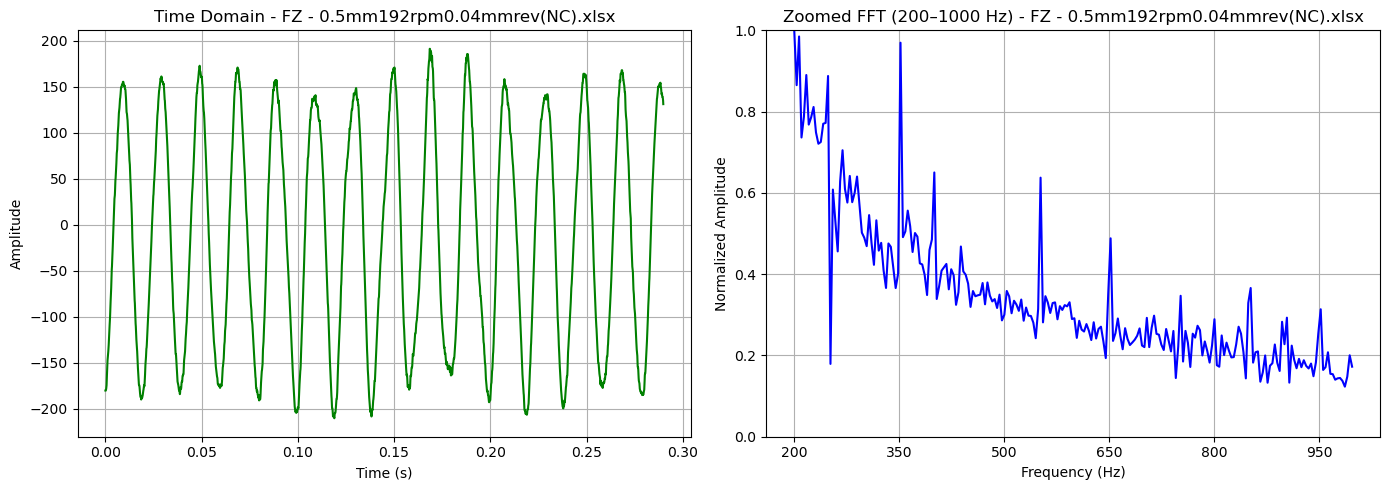


✅ Feature extraction complete: 1503 samples, 24 features


,FZ_mean_fft,FZ_max_fft,FZ_std_fft,FZ_energy,FZ_kurtosis,FZ_skewness,FZ_entropy,FZ_peak_idx,FZ_mean,FZ_std,...,FZ_rms,FZ_crest_factor,FZ_zero_crossings,FZ_ptp,FZ_iqr,DOC,SPEED,FEED,chatter,source_file
0,0.849294,169.293738,8.013641,33249.147335,380.903225,18.673390,0.641203,48.852539,-23.631479,124.529838,...,126.752229,1.668736,10,384.105,247.583300,0.4,192.0,0.04,0,0.4mm192rpm0.04mmrev(NC).xlsx
1,0.936657,164.121204,7.641220,30343.973070,404.429739,19.342568,0.587371,48.852539,-17.266089,120.730085,...,121.958481,1.710476,11,381.196,234.003400,0.4,192.0,0.04,0,0.4mm192rpm0.04mmrev(NC).xlsx
2,0.919384,167.723924,7.715803,30913.985803,424.337067,19.955296,0.498682,48.852539,-15.629277,122.345609,...,123.339865,1.691319,10,377.316,241.763500,0.4,192.0,0.04,0,0.4mm192rpm0.04mmrev(NC).xlsx
3,0.941658,167.145845,7.783183,31469.908360,405.037941,19.418528,0.556182,48.852539,-21.583565,121.668636,...,123.568229,1.688193,10,375.376,239.095875,0.4,192.0,0.04,0,0.4mm192rpm0.04mmrev(NC).xlsx
4,0.883266,165.557190,7.680323,30600.973034,411.331984,19.601414,0.525146,48.852539,-20.107779,120.382070,...,122.049848,1.669457,10,370.526,234.973400,0.4,192.0,0.04,0,0.4mm192rpm0.04mmrev(NC).xlsx


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import kurtosis, skew, entropy as scipy_entropy
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# FFT Function
# -----------------------------
def compute_fft(signal, sampling_rate):
    N = len(signal)
    T = 1.0 / sampling_rate
    xf = fftfreq(N, T)[:N // 2]
    yf = fft(signal)
    amplitude = 2.0 / N * np.abs(yf[:N // 2])
    return xf, amplitude

# -----------------------------
# Zoom FFT to 200–1000 Hz
# -----------------------------
def zoom_fft(xf, amp, f_min=200, f_max=1000):
    mask = (xf >= f_min) & (xf <= f_max)
    return xf[mask], amp[mask]

# -----------------------------
# Chatter Classification
# -----------------------------

# -----------------------------
# Feature Extraction
# -----------------------------
def extract_fft_features(signal, sampling_rate):
    xf, amp = compute_fft(signal, sampling_rate)
    power_spectrum = amp ** 2 + 1e-12
    prob_dist = power_spectrum / np.sum(power_spectrum)

    rms = np.sqrt(np.mean(signal ** 2))
    crest_factor = np.max(np.abs(signal)) / rms if rms != 0 else 0
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    iqr = np.percentile(signal, 75) - np.percentile(signal, 25)

    return {
        'mean_fft': np.mean(amp),
        'max_fft': np.max(amp),
        'std_fft': np.std(amp),
        'energy': np.sum(power_spectrum),
        'kurtosis': kurtosis(amp),
        'skewness': skew(amp),
        'entropy': scipy_entropy(prob_dist),
        'peak_idx': xf[np.argmax(amp)],
        'mean': np.mean(signal),
        'std': np.std(signal),
        'min': np.min(signal),
        'max': np.max(signal),
        'range': np.ptp(signal),
        'median': np.median(signal),
        'rms': rms,
        'crest_factor': crest_factor,
        'zero_crossings': len(zero_crossings),
        'ptp': np.ptp(signal),
        'iqr': iqr
    }

# -----------------------------
# Plot Time and Zoomed FFT with Classification
# -----------------------------
def plot_time_and_fft(signal, sampling_rate, filename, component):
    N = len(signal)
    time_axis = np.arange(N) / sampling_rate
    xf, amp = compute_fft(signal, sampling_rate)
    xf_zoom, amp_zoom = zoom_fft(xf, amp)

    max_amp = np.max(amp_zoom) if np.max(amp_zoom) != 0 else 1
    amp_zoom_normalized = amp_zoom / max_amp
    

    plt.figure(figsize=(14, 5))

    # Time Domain
    plt.subplot(1, 2, 1)
    plt.plot(time_axis, signal, color='green')
    plt.title(f"Time Domain - {component} - {filename}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Zoomed FFT
    plt.subplot(1, 2, 2)
    plt.plot(xf_zoom, amp_zoom_normalized, color='blue')
    plt.title(f"Zoomed FFT (200–1000 Hz) - {component} - {filename}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Amplitude")
    plt.ylim([0, 1])
    plt.grid(True)
    plt.xticks(np.arange(200, 1001, 150))

    plt.tight_layout()
    plt.show()

# -----------------------------
# Parameters
# -----------------------------
folder_path = "/Users/shreyaskumar/Desktop/MLCHATTER"  
segment_size = 1024
step_size = 256
sampling_rate = 10005
plot_signals = True

# -----------------------------
# Process Files
# -----------------------------
all_features = []

for filename in os.listdir(folder_path):
    if filename.endswith(".xlsx") or filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)

        try:
            df = pd.read_excel(file_path) if filename.endswith(".xlsx") else pd.read_csv(file_path)
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            continue

        df = df[pd.to_numeric(df['FZ'], errors='coerce').notnull()]
        df = df.reset_index(drop=True)

        try:
            fz = df['FZ'].astype(float).values
            doc = float(df['DOC'].iloc[0])
            speed = float(df['SPEED'].iloc[0])
            feed = float(df['FEED'].iloc[0])
            chatter = int(df['CHATTER'].iloc[0])

            if plot_signals:
                plot_time_and_fft(fz, sampling_rate, filename, "FZ")

            for i in range(0, len(fz) - segment_size + 1, step_size):
                fz_seg = fz[i:i + segment_size]
                fz_feat = extract_fft_features(fz_seg, sampling_rate)

                combined_feat = {
                    **{f'FZ_{k}': v for k, v in fz_feat.items()},
                    'DOC': doc,
                    'SPEED': speed,
                    'FEED': feed,
                    'chatter': chatter,
                    'source_file': filename,
                }

                all_features.append(combined_feat)

        except Exception as e:
            print(f"Skipping file {filename} due to error: {e}")

# -----------------------------
# Create Final DataFrame
# -----------------------------
features_df = pd.DataFrame(all_features)
print(f"\n✅ Feature extraction complete: {features_df.shape[0]} samples, {features_df.shape[1]} features")
features_df.head()


# OPTION 1:HEATMAP

In [15]:
from sklearn.preprocessing import StandardScaler

# Drop non-numeric or meta columns
X = features_df.drop(columns=['chatter', 'source_file'])

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reconstruct DataFrame with same columns
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Include 'chatter' back for correlation
X_scaled_df['chatter'] = features_df['chatter'].values


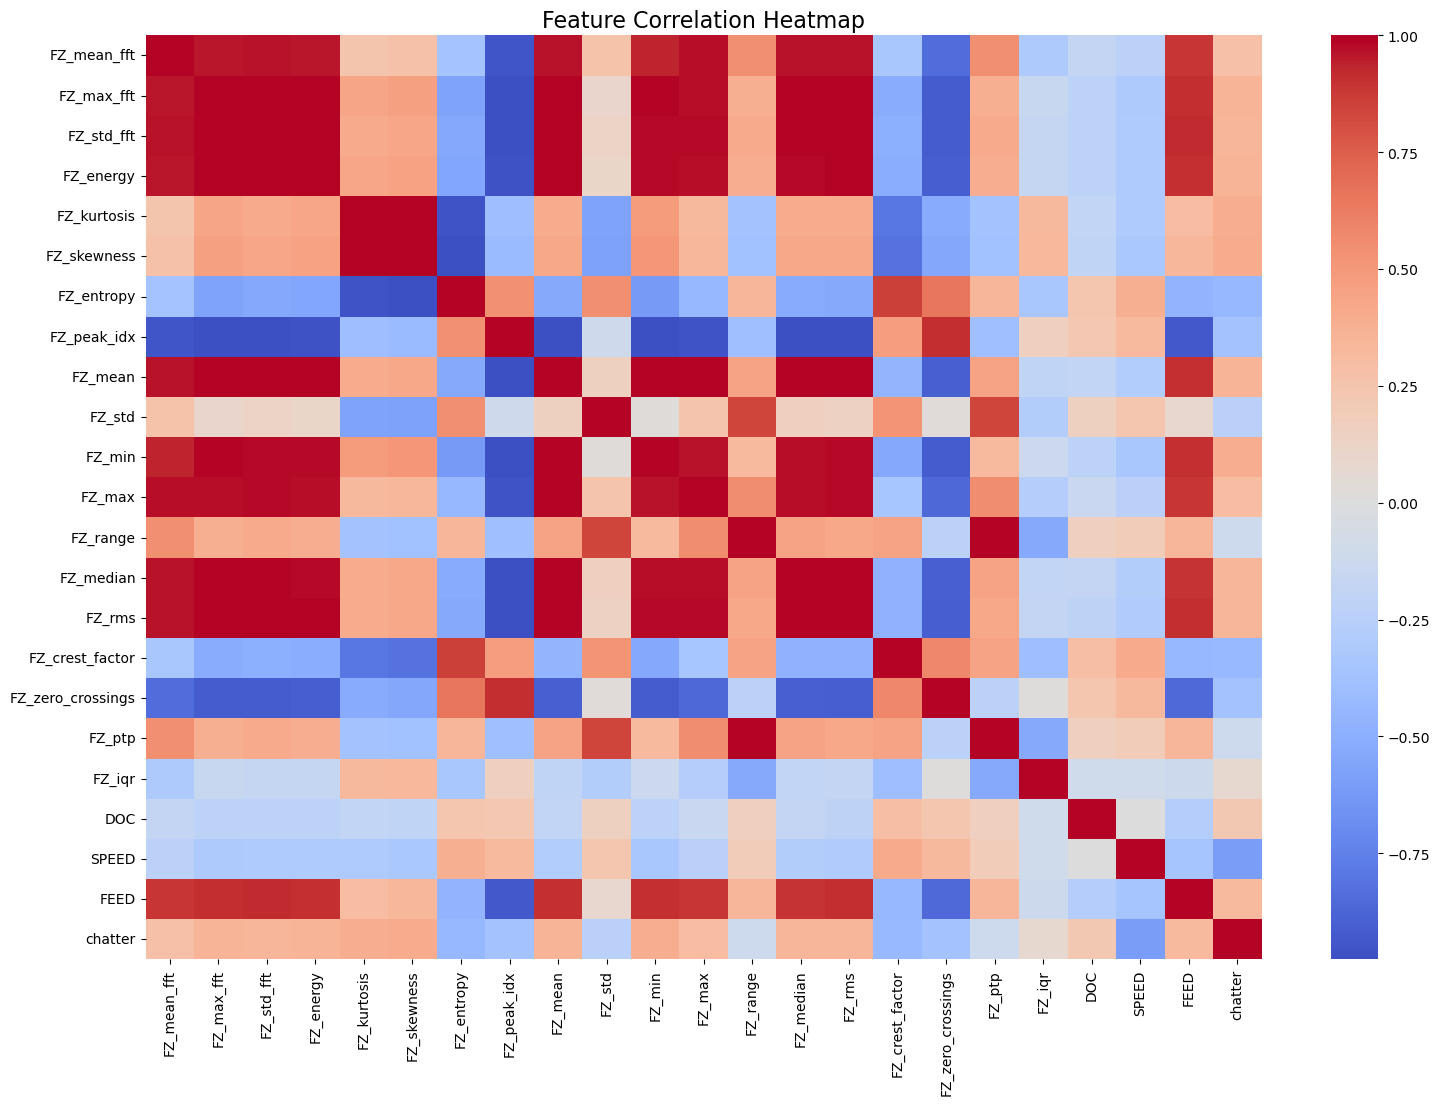

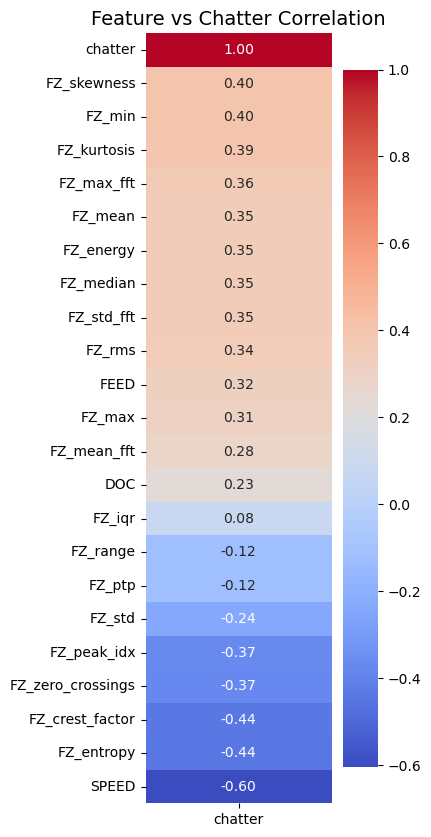

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))
corr = X_scaled_df.corr()

# Optional: focus only on correlation with 'chatter'
chatter_corr = corr[['chatter']].sort_values(by='chatter', ascending=False)

# Full heatmap
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

# Heatmap showing only top correlations with chatter
plt.figure(figsize=(3, 10))
sns.heatmap(chatter_corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Feature vs Chatter Correlation", fontsize=14)
plt.show()


In [4]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=6)  
X_selected = selector.fit_transform(X_scaled_df.drop(columns='chatter'), features_df['chatter'])

# Get selected feature names
selected_cols = X_scaled_df.drop(columns='chatter').columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_cols)
selected_cols

Index(['FZ_mean_fft', 'FZ_std_fft', 'FZ_max', 'FZ_rms', 'SPEED', 'FEED'], dtype='object')

In [9]:
from sklearn.model_selection import train_test_split

X = X_selected_df  # or just use X_scaled_df.drop('chatter') if you didn't select
y = features_df['chatter']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[149   2]
 [ 12 138]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       151
           1       0.99      0.92      0.95       150

    accuracy                           0.95       301
   macro avg       0.96      0.95      0.95       301
weighted avg       0.96      0.95      0.95       301



In [11]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=params, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)
best_model = grid.best_estimator_


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [12]:
y_pred = best_model.predict(X_test)

print("Best Params:", grid.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Confusion Matrix:
 [[149   2]
 [ 11 139]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       151
           1       0.99      0.93      0.96       150

    accuracy                           0.96       301
   macro avg       0.96      0.96      0.96       301
weighted avg       0.96      0.96      0.96       301



In [13]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

Train Accuracy: 1.0000
Test Accuracy:  0.9568


# OPTION2:PCA

In [11]:
from sklearn.preprocessing import StandardScaler

# Drop non-numeric or meta columns
X = features_df.drop(columns=['chatter', 'source_file'])

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reconstruct DataFrame with same columns
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Include 'chatter' back for correlation
X_scaled_df['chatter'] = features_df['chatter'].values


In [12]:
# Separate features and target
X = X_scaled_df.drop(columns=['chatter'])
y = X_scaled_df['chatter']


In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X)

print("Original feature count:", X.shape[1])
print("Reduced feature count (PCA):", X_pca.shape[1])


Original feature count: 22
Reduced feature count (PCA): 5


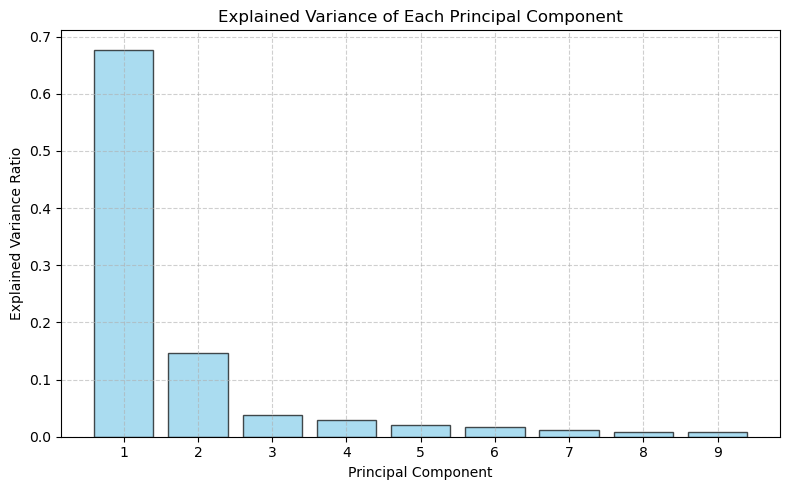

In [35]:
import matplotlib.pyplot as plt
import numpy as np


# Explained variance per component
explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7, color='skyblue', edgecolor='k')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance of Each Principal Component')
plt.xticks(range(1, len(explained_var) + 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)


In [37]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Split the PCA-transformed features
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Train XGBoost Classifier
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Step 3: Predictions
y_pred = xgb_model.predict(X_test)

# Step 4: Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

train_acc = xgb_model.score(X_train, y_train)
test_acc = xgb_model.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")


Confusion Matrix:
 [[153   2]
 [ 13 129]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       155
           1       0.98      0.91      0.95       142

    accuracy                           0.95       297
   macro avg       0.95      0.95      0.95       297
weighted avg       0.95      0.95      0.95       297

Train Accuracy: 0.9992
Test Accuracy:  0.9495
